# Preliminars 

## 1. Targets
The targets for all experiments are Gaussian distributions $\mathcal{N}(\mu, \Sigma)$ with gradient 
$$\nabla E(x) = (x-\mu)\Sigma$$
where $E(x)$ stands for the energy function of the density, i.e., the function such that $f(x) \propto e^{-E(x)}$

## 2. Rates 
Canonical Rates will be considered for all the samplers according to respective definitions.  

## 3. Bounds on the rates
Affine bounds of the form $a+bt$ where used in all the cases. For the ZZ and BPS they could easily be found analytically. 

For the Boomerang sampler a different strategy was used instead. The gradient is used with respect to some Gaussian measure instead of the Lebesgue measure and so the target energy can be written as: 
$$U(x) = E(x) - \frac{1}{2}(x-x_{*})^{T}\Sigma_{*}(x-x_{*}) $$
and thus the gradient becomes 
$$\nabla U(x) = (x-\mu)\Sigma - (x-x_{*})\Sigma_{*}$$
and the norm of the Hessian can be bounded as: 
$$||\nabla^{2}U(x)|| \leq ||\Sigma|| + ||\Sigma_{*}||$$
allowing for an affine bound on the rates $\lambda(t)\leq a + bt$ for some constant values $a,b\in\mathbb{R}$ due to the fact that $\langle x(t)-x_{*}, Qx(t)\rangle + \langle v(t), Qv(t)\rangle$ is constant for any symmetric matrix $Q$ under the Hamiltonian dynamics prescribed. 

# Zig-Zag sampler targeting gaussian 

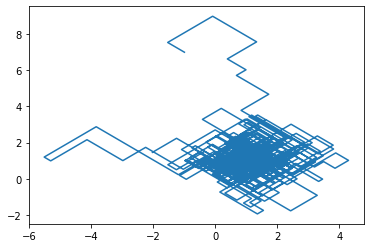

In [105]:
import numpy as np 
import matplotlib.pyplot as plt
from zzsampler import zigzag 


Sigma = np.array([[1,0],[0,1]])
Mu = np.array([1,1])
Sigma_inv = np.linalg.inv(Sigma)
def mult_gaussian_gradient(x):
    grad = np.zeros(len(x))
    for i in range(len(x)):
        grad[i] = np.dot(x-Mu, Sigma_inv[i,:])
    return grad

def bound(t, i, x, v):
    a = np.dot(np.abs(Sigma_inv[i,:]),np.abs(x-Mu))
    b = np.sum(Sigma_inv[i,:])
    return a + t*b

def inv_int_bound(t, x, v):
    evTimes = np.array([])
    for i in range(len(t)):
        a = np.dot(np.abs(Sigma_inv[i, :]), np.abs(x - Mu))
        b = np.sum(np.abs(Sigma_inv[i, :]))
        evTimes = np.append(evTimes, (-a+np.sqrt((a**2)+2*b*t[i]))/b)
    return evTimes

initial_pos = np.array([-1,7])
sampler = zigzag(mult_gaussian_gradient, bound, initial_pos, niter = 1000, inv_int_bound= inv_int_bound)
sampler.sample()

plt.plot(sampler.pos[0], sampler.pos[1])

In [3]:
np.cov(sampler.pos[0], sampler.pos[1])

array([[1.64361679, 0.0619841 ],
       [0.0619841 , 0.0998161 ]])

In [5]:
print("Mean component 1: ", np.mean(sampler.pos[0]), "Mean component 2: ", np.mean(sampler.pos[1]))

Mean component 1 1.0392986017772536 Mean component 2 1.1912349858709472


# Bouncy Particle Sampler targeting Gaussian

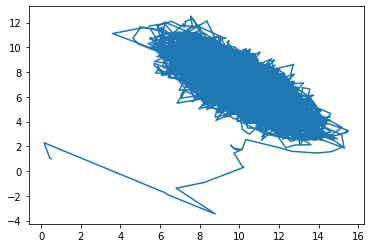

In [6]:
import numpy as np
from bps import bps
import matplotlib.pyplot as plt
Sigma = np.array([[1,-0.7],[-0.7,1]])
Mu = np.array([10,7])
Sigma_inv = np.linalg.inv(Sigma)
def mult_gaussian_gradient(x):
    grad = np.zeros(len(x))
    for i in range(len(x)):
        grad[i] = np.dot(x-Mu, Sigma_inv[i,:])
    return grad

def bound(t, i, x, v):
    a = np.dot(np.abs(Sigma_inv[0, :]), np.abs(x - Mu))
    b = np.sum(np.abs(Sigma_inv[0, :]))
    for i in range(1, len(x)):
        a = a + np.dot(np.abs(Sigma_inv[i, :]), np.abs(x - Mu))
        b = b + np.sum(np.abs(Sigma_inv[i, :]))
    return a + t*b

def inv_int_bound(t, x, v):
    a = np.dot(np.abs(Sigma_inv[0, :]), np.abs(x - Mu))
    b = np.sum(np.abs(Sigma_inv[0, :]))
    for i in range(1, len(x)):
        a = a + np.dot(np.abs(Sigma_inv[i, :]), np.abs(x - Mu))
        b = b + np.sum(np.abs(Sigma_inv[i, :]))
    return (-a + np.sqrt((a ** 2) + 2 * b * t)) / b

initial_pos = np.array([0.5,1])
sampler = bps(mult_gaussian_gradient, bound, initial_pos, niter = 100000, lr = 1, inv_int_bound= inv_int_bound)
sampler.sample()

plt.plot(sampler.pos[0], sampler.pos[1])

In [7]:
np.cov(sampler.pos[0], sampler.pos[1])

array([[ 1.27087837, -0.92232553],
       [-0.92232553,  1.27810689]])

In [8]:
print("Mean component 1: ", np.mean(sampler.pos[0]), "Mean component 2: ", np.mean(sampler.pos[1]))

Mean component 1:  10.01006075185347 Mean component 2:  6.992346163463184


# Boomerang Sampler 

### Example 1: CENTERED ENERGY AND EXACT PRE-CONDITIONING . 
The algorithm reproduces the target distribution reasonably well, probably with an appropriate tuning of the refresh rate this could be even better. 

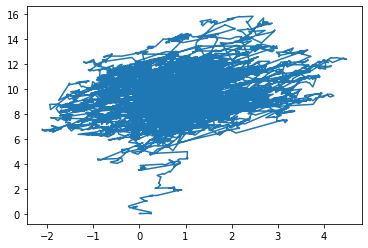

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from boomerang import boomerang

Sigma = np.array([[1,0.5],[0.5,1]])
Mu = np.array([1,10])
Sigma_inv = np.linalg.inv(Sigma)
initial_pos = np.array([0, 0])
mu_ref = np.zeros(2)
sigma_ref = Sigma
sigma_ref_inv = Sigma_inv

def boomerang_gradient(x):
    grad = np.zeros(len(x))
    for i in range(len(x)):
        grad[i] = np.dot(x-Mu, Sigma_inv[i,:]) - np.dot(x-mu_ref, sigma_ref_inv[i,:])
    return grad

def bound(t, i, x, v):
    M = np.linalg.norm(Sigma_inv) + np.linalg.norm(sigma_ref_inv)
    m = np.linalg.norm(boomerang_gradient(np.zeros(2)))
    a = (np.dot(v, boomerang_gradient(x))>0) * (np.dot(v, boomerang_gradient(x)))
    b = M * (np.linalg.norm(x)**2 + np.linalg.norm(v)**2) + m * np.sqrt((np.linalg.norm(x)**2 + np.linalg.norm(v)**2))
    return a + t*b

def inv_int_bound(t, x, v):
    M = np.linalg.norm(Sigma_inv) + np.linalg.norm(sigma_ref_inv)
    m = np.linalg.norm(boomerang_gradient(np.zeros(2)))
    a = (np.dot(v, boomerang_gradient(x))>0) * (np.dot(v, boomerang_gradient(x)))
    b = M * (np.linalg.norm(x)**2 + np.linalg.norm(v)**2) + m * np.sqrt((np.linalg.norm(x)**2 + np.linalg.norm(v)**2))
    return (-a + np.sqrt((a ** 2) + 2 * b * t)) / b


sampler = boomerang(sigma_ref, mu_ref, boomerang_gradient, bound, initial_pos, niter = 10000, lr = 0.15, inv_int_bound= inv_int_bound)
sampler.sample()

plt.plot(sampler.pos[0], sampler.pos[1])

In [107]:
np.cov(sampler.pos[0][2000:], sampler.pos[1][2000:])

array([[1.29714992, 0.55057213],
       [0.55057213, 2.99484155]])

In [108]:
print("Mean component 1: ", np.mean(sampler.pos[0]), "Mean component 2: ", np.mean(sampler.pos[1]))

Mean component 1:  0.9425044155839225 Mean component 2:  9.617841054234356


### Example 2: CENTRED ENERGY BUT NO PRE-CONDITIONING (claiming lack of prior knowledge on the posterior shape).
The algorithm finds the mode of the target reasonably quickly. However it strugles to reproduce exactly the shape of the target, showing some undesired random walk behaviour around the mode. 

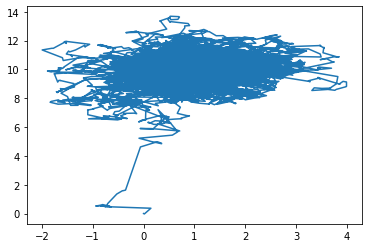

In [42]:
Sigma = np.array([[1,0.5],[0.5,1]])
Mu = np.array([1,10])
Sigma_inv = np.linalg.inv(Sigma)
initial_pos = np.array([0, 0])
mu_ref = Mu
sigma_ref = np.eye(2)
sigma_ref_inv = np.eye(2)

def boomerang_gradient(x):
    grad = np.zeros(len(x))
    for i in range(len(x)):
        grad[i] = np.dot(x-Mu, Sigma_inv[i,:]) - np.dot(x-mu_ref, sigma_ref_inv[i,:])
    return grad

def bound(t, i, x, v):
    M = np.linalg.norm(Sigma_inv) + np.linalg.norm(sigma_ref_inv)
    m = np.linalg.norm(boomerang_gradient(np.zeros(2)))
    a = (np.dot(v, boomerang_gradient(x))>0) * (np.dot(v, boomerang_gradient(x)))
    b = M * (np.linalg.norm(x)**2 + np.linalg.norm(v)**2) + m * np.sqrt((np.linalg.norm(x)**2 + np.linalg.norm(v)**2))
    return a + t*b

def inv_int_bound(t, x, v):
    M = np.linalg.norm(Sigma_inv) + np.linalg.norm(sigma_ref_inv)
    m = np.linalg.norm(boomerang_gradient(np.zeros(2)))
    a = (np.dot(v, boomerang_gradient(x))>0) * (np.dot(v, boomerang_gradient(x)))
    b = M * (np.linalg.norm(x)**2 + np.linalg.norm(v)**2) + m * np.sqrt((np.linalg.norm(x)**2 + np.linalg.norm(v)**2))
    return (-a + np.sqrt((a ** 2) + 2 * b * t)) / b


sampler = boomerang(sigma_ref, mu_ref, boomerang_gradient, bound, initial_pos, niter = 10000, lr = 0.15, inv_int_bound= inv_int_bound)
sampler.sample()

plt.plot(sampler.pos[0], sampler.pos[1])

In [43]:
np.cov(sampler.pos[0][2000:], sampler.pos[1][2000:])

array([[0.80802539, 0.1510541 ],
       [0.1510541 , 0.95125424]])

In [44]:
print("Mean component 1: ", np.mean(sampler.pos[0]), "Mean component 2: ", np.mean(sampler.pos[1]))

Mean component 1:  1.0147644842549792 Mean component 2:  9.87138343739417


### Example 3:  UNCENTRED MEAN AND NO PRE-CONDITIONING 
The algorithm does not converge at all. This is not surprising since both ergodicity and convergence fail since the generator is not exactly the same now. 

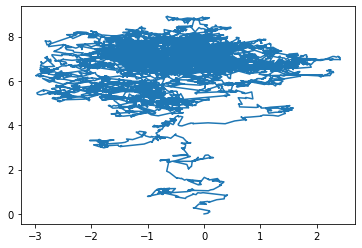

In [53]:
Sigma = np.array([[1,0.5],[0.5,1]])
Mu = np.array([1,10])
Sigma_inv = np.linalg.inv(Sigma)
initial_pos = np.array([0, 0])
mu_ref = np.zeros(2)
sigma_ref = np.eye(2)
sigma_ref_inv = np.eye(2)

def boomerang_gradient(x):
    grad = np.zeros(len(x))
    for i in range(len(x)):
        grad[i] = np.dot(x-Mu, Sigma_inv[i,:]) - np.dot(x-mu_ref, sigma_ref_inv[i,:])
    return grad

def bound(t, i, x, v):
    M = np.linalg.norm(Sigma_inv) + np.linalg.norm(sigma_ref_inv)
    m = np.linalg.norm(boomerang_gradient(np.zeros(2)))
    a = (np.dot(v, boomerang_gradient(x))>0) * (np.dot(v, boomerang_gradient(x)))
    b = M * (np.linalg.norm(x)**2 + np.linalg.norm(v)**2) + m * np.sqrt((np.linalg.norm(x)**2 + np.linalg.norm(v)**2))
    return a + t*b

def inv_int_bound(t, x, v):
    M = np.linalg.norm(Sigma_inv) + np.linalg.norm(sigma_ref_inv)
    m = np.linalg.norm(boomerang_gradient(np.zeros(2)))
    a = (np.dot(v, boomerang_gradient(x))>0) * (np.dot(v, boomerang_gradient(x)))
    b = M * (np.linalg.norm(x)**2 + np.linalg.norm(v)**2) + m * np.sqrt((np.linalg.norm(x)**2 + np.linalg.norm(v)**2))
    return (-a + np.sqrt((a ** 2) + 2 * b * t)) / b


sampler = boomerang(sigma_ref, mu_ref, boomerang_gradient, bound, initial_pos, niter = 10000, lr = 0.07, inv_int_bound= inv_int_bound)
sampler.sample()

plt.plot(sampler.pos[0], sampler.pos[1])

In [54]:
np.cov(sampler.pos[0][2000:], sampler.pos[1][2000:])

array([[0.94573301, 0.10772273],
       [0.10772273, 0.75347601]])

In [55]:
print("Mean component 1: ", np.mean(sampler.pos[0]), "Mean component 2: ", np.mean(sampler.pos[1]))

Mean component 1:  -0.5542772759948521 Mean component 2:  6.586035990695536
